In [33]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import csv
import networkx as nx
import matplotlib.pyplot as plt


In [34]:
m = gp.Model('Maritime Inventory Routing Problem')

# Creating classes in order organize the code

In [35]:
'''
And what is price if it isn't portfee?'''

class Port:
    def __init__(self, capacity, inventory, rate, price, berth_limit, port_fee, max_amount, min_amount, number, isLoadingPort):
        self.capacity = capacity
        self.inventory = inventory
        '''Rate is static for now'''
        self.rate = rate ###
        self.price = price 
        self.berth_limit = berth_limit ###
        self.port_fee = port_fee ###
        self.max_amount = max_amount ###
        self.min_amount = min_amount ###
        self.number = number
        self.isLoadingPort = isLoadingPort
        
    def __repr__(self):
        return f'Port {self.number}'
    

class Node:
    def __init__(self, port, time):
        self.port = port
        self.time = time
        if port==None:
            self.tuple = (None, time)
        else:
            self.tuple = (port.number, time)
        self.incoming_arcs = set()
        self.outgoing_arcs = set()
        self.berths = port.berth_limit
    
    def __repr__(self):
        return str(self.tuple)


class Arc:
    '''Cost should be fixed to the arc for basic MIRP.
    In MIRPSO, the cost is a function of speed and distance. Set to 0 for now.'''
    def __init__(self, origin_node, destination_node, vessel, distance, cost, travel_time):
        self.origin_node = origin_node
        self.destination_node = destination_node
        self.vessel = vessel
        self.tuple = (origin_node, destination_node, vessel)
        self.distance = distance
        self.cost = cost
        self.travel_time = travel_time
    
    def __repr__(self):
        return str(self.origin_node) + ' -> ' + str(self.destination_node)

class Vessel:
    def __init__(self, max_inventory, initial_inventory, max_operating_quantity, number):
        self.max_inventory = int(max_inventory)
        self.inventory = initial_inventory
        self.max_operating_quantity = max_operating_quantity
        self.number = number
        
    def __repr__(self):
        return f'Vessel {self.number}'
        

### Read in file

In [36]:
# Read the content of the provided file
with open("data/LR1_1_DR1_3_VC1_V7a.txt", 'r') as file:
    content = file.read()

In [37]:
def parse_metadata(content):
    metadata = {}
    
    # Extract lines between "----- MetaData -----" and the next section separator (empty line or end of file)
    start_index = content.index("----- MetaData -----") + len("----- MetaData -----")
    end_index = content.find("\n\n", start_index) if "\n\n" in content[start_index:] else len(content)
    
    metadata_section = content[start_index:end_index].strip().split("\n")
    
    for line in metadata_section:
        if ":" in line:
            # Split the line at ":" to extract the key and value
            key, value = line.split(":")
            # Store the key-value pair in the dictionary
            metadata[key.strip()] = value.strip()
    
    return metadata

## Read in metadata

In [38]:
'''Are not using these values:
    spotMarketPricePerUnit = float(metadata['spotMarketPricePerUnit'])
    spotMarketDiscountFactor = float(metadata['spotMarketDiscountFactor'])
    perPeriodRewardForFinishingEarly = float(metadata.get('perPeriodRewardForFinishingEarly', 0))
    attemptCost = float(metadata.get('attemptCost', 0))
    constantForSinglePeriodAlphaSlack = float(metadata.get('constantForSinglePeriodAlphaSlack', 0))
    constantForCumulativeAlphaSlack = float(metadata.get('constantForCumulativeAlphaSlack', 0))'''

def read_and_assign_metadata_from_content(content):
    # Parse the metadata
    metadata = parse_metadata(content)
    
    # Assign the metadata values to variables
    numPeriods = int(metadata['numPeriods'].split()[-1])  # Extract the last word (number) from the string
    numCommodities = int(metadata['numCommodities'])
    numLoadingRegions = int(metadata['numLoadingRegions'])
    numDischargingRegions = int(metadata['numDischargingRegions'])
    numLoadingPortsInRegion = [int(x) for x in metadata['numLoadingPortsInRegion'][1:-1].split()]
    numDischargingPortsInRegion = [int(x) for x in metadata['numDischargingPortsInRegion'][1:-1].split()]
    numVesselClasses = int(metadata['numVesselClasses'])
    numTermVesselsInClass = [int(x) for x in metadata['numTermVesselsInClass'][1:-1].split()]
    hoursPerPeriod = int(metadata['hoursPerPeriod'])
    spotMarketPricePerUnit = float(metadata['spotMarketPricePerUnit'])
    spotMarketDiscountFactor = float(metadata['spotMarketDiscountFactor'])
    perPeriodRewardForFinishingEarly = float(metadata.get('perPeriodRewardForFinishingEarly', 0))
    attemptCost = float(metadata.get('attemptCost', 0))
    constantForSinglePeriodAlphaSlack = float(metadata.get('constantForSinglePeriodAlphaSlack', 0))
    constantForCumulativeAlphaSlack = float(metadata.get('constantForCumulativeAlphaSlack', 0))
    
    # Return the assigned variables
    return {
        'numPeriods': numPeriods,
        'numCommodities': numCommodities,
        'numLoadingRegions': numLoadingRegions,
        'numDischargingRegions': numDischargingRegions,
        'numLoadingPortsInRegion': numLoadingPortsInRegion,
        'numDischargingPortsInRegion': numDischargingPortsInRegion,
        'numVesselClasses': numVesselClasses,
        'numTermVesselsInClass': numTermVesselsInClass,
        'hoursPerPeriod': hoursPerPeriod,
        'spotMarketPricePerUnit': spotMarketPricePerUnit,
        'spotMarketDiscountFactor': spotMarketDiscountFactor,
        'perPeriodRewardForFinishingEarly': perPeriodRewardForFinishingEarly,
        'attemptCost': attemptCost,
        'constantForSinglePeriodAlphaSlack': constantForSinglePeriodAlphaSlack,
        'constantForCumulativeAlphaSlack': constantForCumulativeAlphaSlack
    }

# Using the refactored function with the already-read content
metadata_from_content = read_and_assign_metadata_from_content(content)


# Change the numPeriods manually.
metadata_from_content['numPeriods'] = 4

metadata_from_content

{'numPeriods': 4,
 'numCommodities': 1,
 'numLoadingRegions': 1,
 'numDischargingRegions': 1,
 'numLoadingPortsInRegion': [1],
 'numDischargingPortsInRegion': [3],
 'numVesselClasses': 1,
 'numTermVesselsInClass': [7],
 'hoursPerPeriod': 24,
 'spotMarketPricePerUnit': 1.0,
 'spotMarketDiscountFactor': 0.999,
 'perPeriodRewardForFinishingEarly': 0.01,
 'attemptCost': 0.01,
 'constantForSinglePeriodAlphaSlack': 0.5,
 'constantForCumulativeAlphaSlack': 1.0}

### Read in port data

In [39]:
def parse_region_table(content):
    # Extract the region table section
    start_index = content.index("----- Region Table ----") + len("----- Region Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    
    region_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    
    regions = {}
    for line in region_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            regions[attribute] = values
    
    return regions

def parse_port_table_for_region(content, region_index):
    # Extract the port table section for the specified region
    search_str = f"----- Port Table For Region {region_index} ----"
    start_index = content.index(search_str) + len(search_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    
    port_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    
    ports = {}
    for line in port_section:
        attribute, *values = line.split()
        ports[attribute] = values
    
    return ports

# Extract region and port information
regions_info = parse_region_table(content)
ports_info = {f"Region {i}": parse_port_table_for_region(content, i) for i in range(len(regions_info['NumPorts']))}

ports_info


{'Region 0': {'Capacity': ['594'],
  'Inventory': ['297'],
  'Rate': ['99'],
  'Price': [],
  'BerthLimit': ['1'],
  'PortFee': ['38'],
  'maxAmt': ['300'],
  'minAmt': ['35'],
  'C2R': ['ratio', '6']},
 'Region 1': {'Capacity': ['351', '510', '312'],
  'Inventory': ['168', '255', '156'],
  'Rate': ['-39', '-34', '-26'],
  'Price': ['5', '5', '5'],
  'BerthLimit': ['1', '1', '1'],
  'PortFee': ['57', '58', '66'],
  'maxAmt': ['300', '300', '259'],
  'minAmt': ['50', '35', '20'],
  'C2R': ['ratio', '9', '15', '12']}}

### Create the ports

In [40]:
def create_ports_from_info_with_loading(ports_info):
    all_ports = {}
    
    tot_num = 1
    for region_idx, (region, port_attributes) in enumerate(ports_info.items()):
        region_ports = []
        for i in range(len(port_attributes['Capacity'])):
            port = Port(
                capacity=int(port_attributes['Capacity'][i]) if 'Capacity' in port_attributes else None,
                inventory=int(port_attributes['Inventory'][i]) if 'Inventory' in port_attributes else None,
                rate=int(port_attributes['Rate'][i]) if 'Rate' in port_attributes else None,
                price=int(port_attributes['Price'][i]) if 'Price' in port_attributes and port_attributes['Price'] else None,
                berth_limit=int(port_attributes['BerthLimit'][i]) if 'BerthLimit' in port_attributes else None,
                port_fee=int(port_attributes['PortFee'][i]) if 'PortFee' in port_attributes else None,
                max_amount=int(port_attributes['maxAmt'][i]) if 'maxAmt' in port_attributes else None,
                min_amount=int(port_attributes['minAmt'][i]) if 'minAmt' in port_attributes else None,
                number=int(tot_num),  # Using 1 to numports+1 as the port number
                isLoadingPort=(region_idx == 0)  # Set loadingPort to True if the region is the first one
            )
            region_ports.append(port)
            tot_num += 1
        all_ports[region] = region_ports
    
    return all_ports

In [41]:
all_ports = create_ports_from_info_with_loading(ports_info)

In [42]:
# Create a list of all ports
ports = []
for region, region_ports in all_ports.items():
    ports.extend(region_ports)

In [43]:
ports

[Port 1, Port 2, Port 3, Port 4]

Metadata loaded in. Use only the most important data in the beginning. 

- numPeriods
- numTermVesselsInClass (If only 1 numVesselClasses we have homogenous fleet.)
- Set of ports:
    - numLoadingRegions x numLoadingPortsInRegion
    - numDischargingPortsInRegion x numDischargingPortsInRegion
- Set of regular nodes
    - Needs to be created based on the timeperiods and ports.
- Set of all nodes
    - Add sink and source node to the set of regular nodes.

- The arcs do also need to be included

# Initial Parameters

All parameters should be set below

In [44]:
# Time periods
numTimePeriods = metadata_from_content['numPeriods']
timePeriodRange = list(range(1, numTimePeriods+1))

# Number of vessels
numVessels = metadata_from_content['numTermVesselsInClass'][0]

# # Number of ports
# numLoadingPorts = 0
# for i in range(variables['numLoadingRegions']):
#     numLoadingPorts += variables['numLoadingPortsInRegion'][i]

# numDischargingPorts = 0
# for i in range(variables['numDischargingRegions']):
#     numDischargingPorts += variables['numDischargingPortsInRegion'][i]


In [45]:
numTimePeriods

4

In [46]:
def parse_vessel_table(content):
    # Extract the vessel table section
    start_index = content.index("----- Vessel Table ----") + len("----- Vessel Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    
    vessel_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    
    vessels = {}
    for line in vessel_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            vessels[attribute] = values
    
    return vessels

In [47]:
# Extract vessel information
vessels_info = parse_vessel_table(content)

vessels_info

{'Type': ['Term', 'Term', 'Term', 'Term', 'Term', 'Term', 'Term'],
 'Class': ['0', '0', '0', '0', '0', '0', '0'],
 'Capacity': ['300', '300', '300', '300', '300', '300', '300']}

In [48]:
# Create a dictionary with key = vessel class and value = vessel object
vessels = {}
tot = 1
for vessel_class in range(metadata_from_content['numVesselClasses']):
    vessel_list = []
    vessels_in_class = metadata_from_content['numTermVesselsInClass'][vessel_class]
    for i in range(vessels_in_class):
        vessel_list.append(Vessel(
            max_inventory=int(vessels_info['Capacity'][i]),
            initial_inventory=int(0),
            max_operating_quantity=int(vessels_info['Capacity'][i]),
            number=tot
        ))
        tot += 1
    vessels[vessel_class] = vessel_list


In [49]:
# Create the regular nodes
regularNodes = []
for t in range(1, numTimePeriods+1):
    for port in ports:
        node = Node(port=port, time=t)
        regularNodes.append(node)
    
# Create fictional source and sink port
sourcePort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=0, isLoadingPort=True)
sinkPort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=len(ports)+1, isLoadingPort=False)

# Create source and sink node
sourceNode = Node(port=sourcePort, time=0)
sinkNode = Node(port=sinkPort, time=numTimePeriods+1)

nodes = [sourceNode] + regularNodes + [sinkNode]

### Read in arc data

In [50]:
def parse_full_distance_matrix(content):
    
    # Extract the full distance matrix section
    start_str = "----- FullDistanceMatrix ----"
    start_index = content.index(start_str) + len(start_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    
    matrix_section = content[start_index:end_index].strip().split("\n")[2:]  # Exclude the header lines
    
    # Convert the matrix section to a 2D list of distances
    distances = []
    for line in matrix_section:
        try:
            distance_row = list(map(float, line.split()[1:]))  # Excluding the leading port number
            distances.append(distance_row)
        except ValueError:
            continue
    
    return distances

# Extracting the full distance matrix from the file content
full_distance_matrix = parse_full_distance_matrix(content)

full_distance_matrix


[[0.0, 5792.83, 5730.94, 5663.71],
 [5792.83, 0.0, 326.1, 338.92],
 [5730.94, 326.1, 0.0, 67.42],
 [5663.71, 338.92, 67.42, 0.0]]

In [51]:
def parse_full_distance_matrix_for_class(content):
    numVesselClasses = metadata_from_content['numVesselClasses']
    # Extract the full distance matrix section
    search_str = "----- FullDistanceMatrix ----"
    start_index = content.index(search_str) + len(search_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    
    matrix_section = content[start_index:end_index].strip().split("\n")[2:]  # Exclude the header lines

    # Convert the matrix section to a 2D list of distances
    matrix = []
    for line in matrix_section:
        try:
            distance_row = list(map(float, line.split()[1:]))  # Excluding the leading port number
            matrix.append(distance_row)
        except ValueError:
            continue

    # Given that there's only one full distance matrix for all vessel classes,
    # we replicate it for each class
    matrices = {f"Class {i}": matrix for i in range(numVesselClasses)}
    
    return matrices

# Extracting the full distance matrix from the file content in the desired dictionary format
full_distance_matrices = parse_full_distance_matrix_for_class(content)

full_distance_matrices


{'Class 0': [[0.0, 5792.83, 5730.94, 5663.71],
  [5792.83, 0.0, 326.1, 338.92],
  [5730.94, 326.1, 0.0, 67.42],
  [5663.71, 338.92, 67.42, 0.0]]}

Proceeding with the travel time between every pair of ports.

In [52]:
def parse_full_travel_time_matrix(content):
    matrices = {}
    numVesselClasses = metadata_from_content['numVesselClasses']
    
    for v_class in range(numVesselClasses):
        search_str = f"----- FullTravelTimeMatrixForClass -----"
        start_index = content.index(search_str, content.index(f"Vessel_Class_{v_class}")) + len(search_str)
        end_index = content.find("-----", start_index)  # Find the next section separator

        matrix_section = content[start_index:end_index].strip().split("\n")[2:]  # Exclude the header lines

        matrix = []
        for line in matrix_section:
            # Try to split and convert the values in the line to integers
            try:
                # Excluding the first column (index)
                values = [int(val) for val in line.split()[1:]]
                matrix.append(values)
            except ValueError:
                # Skip lines that don't contain integer values
                continue

        matrices[f"Class {v_class}"] = matrix
    
    return matrices


# Extract travel time matrix information for each vessel class without the index column
travel_time_matrices = parse_full_travel_time_matrix(content)

travel_time_matrices




{'Class 0': [[0, 9, 9, 9], [9, 0, 1, 1], [9, 1, 0, 1], [9, 1, 1, 0]]}

In [53]:
def parse_full_travel_cost_matrix_for_class(content):
    matrices = {}
    numVesselClasses = metadata_from_content['numVesselClasses']
    
    for v_class in range(numVesselClasses):
        search_str = f"----- FullTravelCostMatrixForClass -----"
        start_index = content.index(search_str, content.index(f"Vessel_Class_{v_class}")) + len(search_str)
        end_index = content.find("-----", start_index)  # Find the next section separator

        matrix_section = content[start_index:end_index].strip().split("\n")[2:]  # Exclude the header lines

        matrix = []
        for line in matrix_section:
            # Try to split and convert the values in the line to integers
            try:
                # Excluding the first column (index)
                values = [float(val) for val in line.split()[1:]]  # Using float here since cost can be a decimal value
                matrix.append(values)
            except ValueError:
                # Skip lines that don't contain float values
                continue

        matrices[f"Class {v_class}"] = matrix
    
    return matrices

# Extract travel cost matrix information for each vessel class without the index column
travel_cost_matrices = parse_full_travel_cost_matrix_for_class(content)

travel_cost_matrices


{'Class 0': [[38.0, 491.0, 487.0, 490.0],
  [472.0, 57.0, 82.0, 91.0],
  [467.0, 81.0, 58.0, 71.0],
  [462.0, 82.0, 63.0, 66.0]]}

Now all arc data is loaded in.
 
Should now create all of the arcs.

In [54]:
def incoming_arcs_v2(node, nodes, vessel, vessel_class):
    return {
        Arc(
            origin_node=i,
            destination_node=node,
            vessel = vessel,
            distance=full_distance_matrices[f"Class {vessel_class}"][i.port.number-1][node.port.number-1],
            travel_time=travel_time_matrices[f"Class {vessel_class}"][i.port.number-1][node.port.number-1],
            cost=travel_cost_matrices[f"Class {vessel_class}"][i.port.number-1][node.port.number-1]
        )
        for i in regularNodes if i.time < node.time
    }

def outgoing_arcs_v2(node, nodes, vessel, vessel_class):
    return {
        Arc(
            origin_node=node,
            destination_node=j,
            vessel = vessel,
            distance=full_distance_matrices[f"Class {vessel_class}"][node.port.number-1][j.port.number-1],
            travel_time=travel_time_matrices[f"Class {vessel_class}"][node.port.number-1][j.port.number-1],
            cost=travel_cost_matrices[f"Class {vessel_class}"][node.port.number-1][j.port.number-1]
        )
        for j in regularNodes if node.time < j.time
    }


# Sets

Initializing sets

In [55]:
'''Using the parsed data instead'''

# Create the set of arcs associated with vessel v in a time-space model
# Note: The arcs need to be revised so that only feasible travels are included
def generate_all_arcs(regularNodes, vesselClass):
    arc_dict = {}
    vessels_in_vessel_class = vessels[vesselClass]
    for v in vessels_in_vessel_class:
        # Arcs between all nodes
        for n in regularNodes:
            arcs = set()
            outgoing_arcs_for_node_n_vessel_v = outgoing_arcs_v2(node=n, nodes=nodes, vessel=v, vessel_class=vessel_class)
            arcs.update(outgoing_arcs_for_node_n_vessel_v)
            arc_dict[(n.tuple, v)] = arcs
    return arc_dict

In [56]:
# Create the arcs
numVesselClasses = metadata_from_content['numVesselClasses']
all_arcs = {}
for c in range(numVesselClasses):
    all_arcs[c] = generate_all_arcs(regularNodes, c)
    


In [57]:
print(all_arcs)

{0: {((1, 1), Vessel 1): {(1, 1) -> (4, 2), (1, 1) -> (4, 4), (1, 1) -> (1, 3), (1, 1) -> (2, 4), (1, 1) -> (1, 2), (1, 1) -> (3, 4), (1, 1) -> (3, 2), (1, 1) -> (2, 3), (1, 1) -> (3, 3), (1, 1) -> (2, 2), (1, 1) -> (1, 4), (1, 1) -> (4, 3)}, ((2, 1), Vessel 1): {(2, 1) -> (3, 3), (2, 1) -> (2, 4), (2, 1) -> (2, 2), (2, 1) -> (2, 3), (2, 1) -> (4, 4), (2, 1) -> (1, 3), (2, 1) -> (1, 4), (2, 1) -> (4, 2), (2, 1) -> (4, 3), (2, 1) -> (3, 4), (2, 1) -> (3, 2), (2, 1) -> (1, 2)}, ((3, 1), Vessel 1): {(3, 1) -> (3, 2), (3, 1) -> (3, 3), (3, 1) -> (2, 2), (3, 1) -> (2, 3), (3, 1) -> (1, 2), (3, 1) -> (4, 4), (3, 1) -> (1, 3), (3, 1) -> (3, 4), (3, 1) -> (2, 4), (3, 1) -> (4, 2), (3, 1) -> (1, 4), (3, 1) -> (4, 3)}, ((4, 1), Vessel 1): {(4, 1) -> (3, 3), (4, 1) -> (1, 2), (4, 1) -> (2, 3), (4, 1) -> (2, 4), (4, 1) -> (4, 3), (4, 1) -> (3, 4), (4, 1) -> (1, 3), (4, 1) -> (4, 4), (4, 1) -> (1, 4), (4, 1) -> (4, 2), (4, 1) -> (3, 2), (4, 1) -> (2, 2)}, ((1, 2), Vessel 1): {(1, 2) -> (2, 4), (1, 

In [58]:
total_arcs = 0
for c in range(numVesselClasses):
    for n in regularNodes:
        for v in vessels[c]:
            total_arcs += len(all_arcs[c][(n.tuple, v)])
            
total_arcs

672

In [89]:
# Add the arcs from sourceNode to all regular nodes and from all regular nodes to sinkNode
for c in range(numVesselClasses):
    for vessel in vessels[c]:
        for n in regularNodes:
            arc_set = set()
            arc_set.add(Arc(origin_node=sourceNode, destination_node=n, vessel=vessel, distance=0, cost=0, travel_time=0))
            arc_set.add(Arc(origin_node=n, destination_node=sinkNode, vessel=vessel, distance=0, cost=0, travel_time=0))
            if (n.tuple, vessel) not in all_arcs[c]:
                all_arcs[c][(n.tuple, vessel)] = set()
            all_arcs[c][(n.tuple, vessel)].update(arc_set)

            
    
# Add one arc from sourceNode to sinkNode
for c in range(numVesselClasses):
    for vessel in vessels[c]:
        all_arcs[c][sourceNode.tuple, vessel] = {Arc(origin_node=sourceNode, destination_node=sinkNode, vessel=vessel, distance=0, cost=0, travel_time=0)}
    
    
# Add an empty set for the sinkNode
for c in range(numVesselClasses):
    for vessel in vessels[c]:
        all_arcs[c][sinkNode.tuple, vessel] = {}
    
print(all_arcs)

{0: {((1, 1), Vessel 1): {(1, 1) -> (5, 5), (0, 0) -> (1, 1), (1, 1) -> (5, 5), (0, 0) -> (1, 1)}, ((2, 1), Vessel 1): {(2, 1) -> (5, 5), (2, 1) -> (5, 5), (0, 0) -> (2, 1), (0, 0) -> (2, 1)}, ((3, 1), Vessel 1): {(3, 1) -> (5, 5), (3, 1) -> (5, 5), (0, 0) -> (3, 1), (0, 0) -> (3, 1)}, ((4, 1), Vessel 1): {(4, 1) -> (5, 5), (4, 1) -> (5, 5), (0, 0) -> (4, 1), (0, 0) -> (4, 1)}, ((1, 2), Vessel 1): {(1, 2) -> (5, 5), (1, 2) -> (5, 5), (0, 0) -> (1, 2), (0, 0) -> (1, 2)}, ((2, 2), Vessel 1): {(2, 2) -> (5, 5), (2, 2) -> (5, 5), (0, 0) -> (2, 2), (0, 0) -> (2, 2)}, ((3, 2), Vessel 1): {(3, 2) -> (5, 5), (3, 2) -> (5, 5), (0, 0) -> (3, 2), (0, 0) -> (3, 2)}, ((4, 2), Vessel 1): {(4, 2) -> (5, 5), (0, 0) -> (4, 2), (0, 0) -> (4, 2), (4, 2) -> (5, 5)}, ((1, 3), Vessel 1): {(0, 0) -> (1, 3), (1, 3) -> (5, 5), (1, 3) -> (5, 5), (0, 0) -> (1, 3)}, ((2, 3), Vessel 1): {(2, 3) -> (5, 5), (0, 0) -> (2, 3), (0, 0) -> (2, 3), (2, 3) -> (5, 5)}, ((3, 3), Vessel 1): {(3, 3) -> (5, 5), (0, 0) -> (3, 3)

In [90]:
all_arcs[0]

{((1, 1), Vessel 1): {(0, 0) -> (1, 1),
  (0, 0) -> (1, 1),
  (1, 1) -> (5, 5),
  (1, 1) -> (5, 5)},
 ((2, 1), Vessel 1): {(0, 0) -> (2, 1),
  (0, 0) -> (2, 1),
  (2, 1) -> (5, 5),
  (2, 1) -> (5, 5)},
 ((3, 1), Vessel 1): {(0, 0) -> (3, 1),
  (0, 0) -> (3, 1),
  (3, 1) -> (5, 5),
  (3, 1) -> (5, 5)},
 ((4, 1), Vessel 1): {(0, 0) -> (4, 1),
  (0, 0) -> (4, 1),
  (4, 1) -> (5, 5),
  (4, 1) -> (5, 5)},
 ((1, 2), Vessel 1): {(0, 0) -> (1, 2),
  (0, 0) -> (1, 2),
  (1, 2) -> (5, 5),
  (1, 2) -> (5, 5)},
 ((2, 2), Vessel 1): {(0, 0) -> (2, 2),
  (0, 0) -> (2, 2),
  (2, 2) -> (5, 5),
  (2, 2) -> (5, 5)},
 ((3, 2), Vessel 1): {(0, 0) -> (3, 2),
  (0, 0) -> (3, 2),
  (3, 2) -> (5, 5),
  (3, 2) -> (5, 5)},
 ((4, 2), Vessel 1): {(0, 0) -> (4, 2),
  (0, 0) -> (4, 2),
  (4, 2) -> (5, 5),
  (4, 2) -> (5, 5)},
 ((1, 3), Vessel 1): {(0, 0) -> (1, 3),
  (0, 0) -> (1, 3),
  (1, 3) -> (5, 5),
  (1, 3) -> (5, 5)},
 ((2, 3), Vessel 1): {(0, 0) -> (2, 3),
  (0, 0) -> (2, 3),
  (2, 3) -> (5, 5),
  (2, 3) ->

In [86]:
for c in range(numVesselClasses):
    for n in regularNodes:
        for v in vessel[c]:
            


[(1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (1, 2),
 (2, 2),
 (3, 2),
 (4, 2),
 (1, 3),
 (2, 3),
 (3, 3),
 (4, 3),
 (1, 4),
 (2, 4),
 (3, 4),
 (4, 4)]

In [61]:
# # Create a set of all arcs no matter what the vessel and vessel class is
# all_arcs_set = set()
# for c in range(numVesselClasses):
#     for n in nodes:
#         for v in vessels[c]:
#             # If we have an arc that have the same representation, we only add one of them
            
            
            
all_arcs_set = set()
for c in range(numVesselClasses):
    for n in nodes:
        for v in vessels[c]:
            # Check each arc in the current vessel class, node, and vessel combination
            for arc in all_arcs[c][(n.tuple, v)]:
                # If the representation of the arc isn't in the set, add the arc itself
                if arc.__repr__() not in all_arcs_set:
                    all_arcs_set.add(arc)

            
all_arcs_set

{(0, 0) -> (1, 1),
 (0, 0) -> (1, 1),
 (0, 0) -> (1, 1),
 (0, 0) -> (1, 1),
 (0, 0) -> (1, 1),
 (0, 0) -> (1, 1),
 (0, 0) -> (1, 1),
 (0, 0) -> (1, 2),
 (0, 0) -> (1, 2),
 (0, 0) -> (1, 2),
 (0, 0) -> (1, 2),
 (0, 0) -> (1, 2),
 (0, 0) -> (1, 2),
 (0, 0) -> (1, 2),
 (0, 0) -> (1, 3),
 (0, 0) -> (1, 3),
 (0, 0) -> (1, 3),
 (0, 0) -> (1, 3),
 (0, 0) -> (1, 3),
 (0, 0) -> (1, 3),
 (0, 0) -> (1, 3),
 (0, 0) -> (1, 4),
 (0, 0) -> (1, 4),
 (0, 0) -> (1, 4),
 (0, 0) -> (1, 4),
 (0, 0) -> (1, 4),
 (0, 0) -> (1, 4),
 (0, 0) -> (1, 4),
 (0, 0) -> (2, 1),
 (0, 0) -> (2, 1),
 (0, 0) -> (2, 1),
 (0, 0) -> (2, 1),
 (0, 0) -> (2, 1),
 (0, 0) -> (2, 1),
 (0, 0) -> (2, 1),
 (0, 0) -> (2, 2),
 (0, 0) -> (2, 2),
 (0, 0) -> (2, 2),
 (0, 0) -> (2, 2),
 (0, 0) -> (2, 2),
 (0, 0) -> (2, 2),
 (0, 0) -> (2, 2),
 (0, 0) -> (2, 3),
 (0, 0) -> (2, 3),
 (0, 0) -> (2, 3),
 (0, 0) -> (2, 3),
 (0, 0) -> (2, 3),
 (0, 0) -> (2, 3),
 (0, 0) -> (2, 3),
 (0, 0) -> (2, 4),
 (0, 0) -> (2, 4),
 (0, 0) -> (2, 4),
 (0, 0) -> (

In [66]:
# Create the arcs for each node

for n in nodes:
    for a in all_arcs_set:
        if a.origin_node.tuple == n.tuple:
            n.outgoing_arcs.add(a)
        if a.destination_node.tuple == n.tuple:
            n.incoming_arcs.add(a)

## Visualization of graph

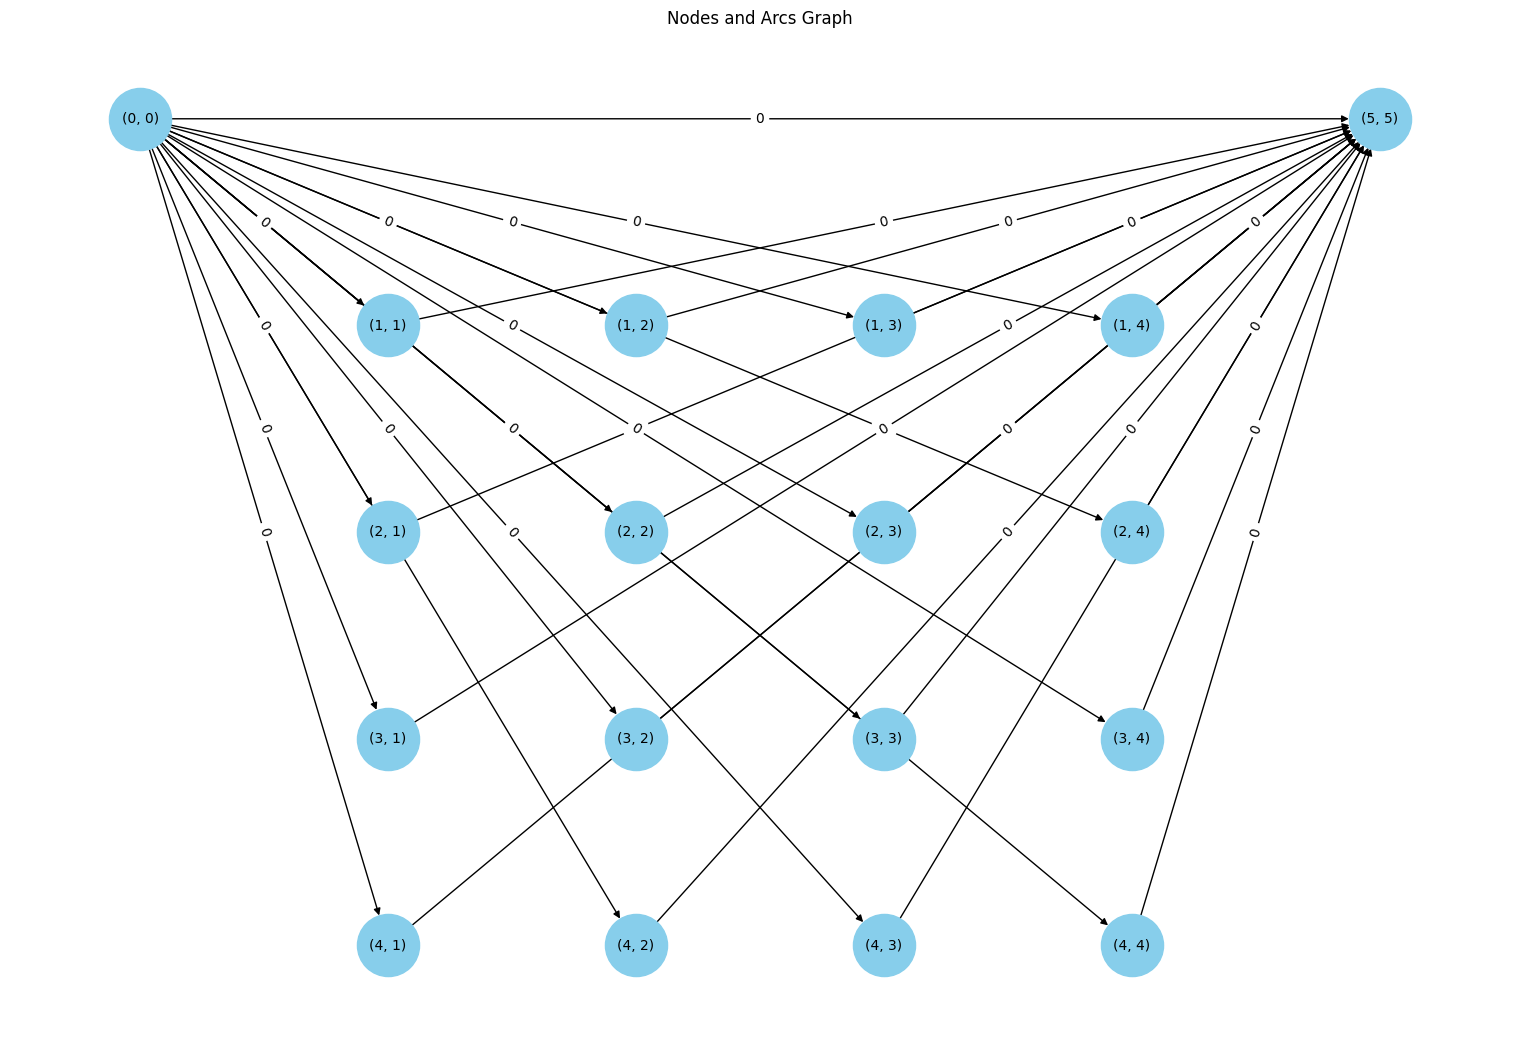

In [68]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(str(node.tuple))

# Add edges (arcs) to the graph
for arc in all_arcs_set:
    G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple), weight=arc.cost)

# Resetting the y_offset and y_spacing
y_offset = 10
y_spacing = -30  # Increase vertical spacing for better clarity

# Manually specify the positions for each node
pos = {}

# Manually set the position for the source and sink nodes
pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

for node in nodes:
    # Skip setting position for source and sink nodes
    if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        continue
    port_index = node.port.number  # Get port number to determine y-coordinate
    # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
    pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

# Drawing the graph using the adjusted positions
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Nodes and Arcs Graph")
plt.show()


All nodes and arcs have been created. However there are arcs between all nodes, even though it may be infeasible for a vessel to travel the distance in time. 

We should therefore remove some of the arcs, based on feasiblity in regards to the speed. 

In addition, in the beginning of the planning period, if the vessel inventory is empty, we can remove all the arcs that go to discharging ports.
### Unsure how to solve the initial problem when vessels have different starting locations. The distance to the ports will then vary. 


# Starting with Gurobi

In [ ]:
vessels

{0: [Vessel 1, Vessel 2, Vessel 3, Vessel 4, Vessel 5, Vessel 6, Vessel 7]}

In [ ]:
'''Creating the variables'''
'''Binary first'''
# x is the binary variable that indicates whether a vessel travels on arc a, where and arc is a route frome one node to another node. 
x = m.addVars((arc.tuple for arc in all_arcs_set), vtype=GRB.BINARY, name="x")

# o is the binary variable that indicates whether vessel v is operating (loading/unloading) at port p at time t
o = m.addVars(((port.number, t, vessel) for port in ports for t in timePeriodRange for vessel in vessels), vtype=GRB.BINARY, name="o")

'''Continuous varibles'''
# q is the amount of product loaded or unloaded at port i by vessel v at time t
q_bounds = {(port.number, t, vessel): min(vessel.max_inventory, port.capacity) for port in ports for t in timePeriodRange for c in range(numVesselClasses) for vessel in vessels[c]}
q = m.addVars(q_bounds.keys(), lb=0, ub=q_bounds, vtype=GRB.CONTINUOUS, name="q")

# s is the amount of product at port i at the end of period t
s_bounds = {(port.number, t): port.capacity for port in ports for t in timePeriodRange}
s = m.addVars(s_bounds.keys(), lb=0, ub=s_bounds, vtype=GRB.CONTINUOUS, name="s")
# Create s vars for each port in time period 0
s_bounds_source = {(port.number, 0): port.capacity for port in ports}
s_source = m.addVars(s_bounds_source.keys(), lb=0, ub=s_bounds, vtype=GRB.CONTINUOUS, name="s")
s.update(s_source)

# w is the amount of product on board of vessel v at the end of time period t
w_bounds = {(t, vessel): vessel.max_inventory for c in range(numVesselClasses) for vessel in vessels[c] for t in timePeriodRange}
w = m.addVars(w_bounds.keys(), lb=0, ub=w_bounds, vtype=GRB.CONTINUOUS, name="w")
w_bounds_source = {(0, vessel): vessel.max_inventory for c in range(numVesselClasses) for vessel in vessels[c]}
w_source = m.addVars(w_bounds_source.keys(), lb=0, ub=w_bounds, vtype=GRB.CONTINUOUS, name="w")
w.update(w_source)

m.update()

In [ ]:
# Create a dict where the arc.tuple is the key and arc.cost is the value
costs = {(arc.tuple): arc.cost for arc in all_arcs_set}

### Objective Function

In [ ]:
obj = gp.quicksum(costs[key]*x[key] for key in costs)

#Minimize the costs
m.setObjective(obj, GRB.MINIMIZE)

m.update()

### Constraints

In [ ]:
# Constraint (2)
for c in range(numVesselClasses):
    for i in range(len(vessels[c])):
        m.addConstr(gp.quicksum(x[arc.tuple, i] for arc in sourceNode.outgoing_arcs) == 1, name = 'SourceFlow')

In [ ]:
# Constraint (3)
for c in range(numVesselClasses):
    for i in range(len(vessels[c])):
        m.addConstr(gp.quicksum(x[arc.tuple] for arc in sinkNode.incoming_arcs) == 1, name = 'SinkFlow')

In [ ]:
# Constraint (4)
# Creating a flow balance constraint for each node
for c in range(numVesselClasses):
    for i in range(len(vessels[c])):
        for node in regularNodes:
            m.addConstr(gp.quicksum(x[in_arc.tuple] for in_arc in node.incoming_arcs) - gp.quicksum(x[out_arc.tuple] for out_arc in node.outgoing_arcs) == 0, name = "FlowBalance")


In [ ]:
s_bounds.keys()

dict_keys([(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)])

In [ ]:
# Constraint (5)
for port in ports:
    m.addConstr(s_source[port.number, 0] == port.inventory, name = 'InitialInventoryPort')

In [ ]:
# Constraint (6)
'''Rate is static for now'''
for node in regularNodes:
    m.addConstr(s[port.number, node.time] == s[port.number, node.time-1] + node.port.isLoadingPort * node.port.rate - gp.quicksum(node.port.isLoadingPort * q[node.port.number, node.time, v] for c in range(numVesselClasses) for v in vessels[c]) , name = 'InventoryBalance')
    

In [ ]:
# Constraint (7)
for c in range(numVesselClasses):
    for v in vessels[c]:
        m.addConstr(w_source[0, v] == v.inventory, name = 'InitialInventoryVessel')


In [ ]:
# Constraint (8)
for c in range(numVesselClasses):
    for v in vessels[c]:
        for t in timePeriodRange:
            m.addConstr(w[t, v] == w[t-1, v] + gp.quicksum(node.port.isLoadingPort * q[node.port.number, t, v] for node in regularNodes), name = 'VesselBalance')
    

In [ ]:
# Constraint (9)
